______
<img src="./imgs/DRRlogo.jpg" width="350" />

# Land Cover Classification for use in the CAPRA Model 

## Image Enhancement in GEE
_____

Image enhancement refers to procedures used to adjust the values in a remotely sensed image to improve its visual qualities for a specific purpose. The brightness values at individual pixels are changed to achieve improved brightness, contrast, color balance, or other qualities.  

The visual quality of an image is related to the range of brightness in the image, known as contrast. A high contrast image has a narrow range of brightness (mainly blacks and whites). A low contrast image has a wide range of brightness. Usually, excessive contrast is undesirable; as we cannot see features depicted in the intermediate grey that usually form the most
important part of an image. On the other hand, lack of contrast is usually undesirable as we cannot see edges.

Image enhancement is a tool that allows us to apply the level of contrast appropriate for a specific purpose. It is important to recognize that image enhancement is intended to improve the appearance of a specific image for a specific purpose.Peferred enhancement techniques will vary from one application to the next depending on the project's objectives. Image enhancement focuses entirely on manipulating the appearance of the image, so it is fundamentally cosmetic in nature, and should not be used as input for analytical purposes. 

#### Raster Symbolizer

In previous examples, multiband images were displayed in RGB combination providing the *min* and *max*  parameters to strecth digital levels to 0 - 256 values.  A Styled Layer Descriptor (SLD) can also be used in GEE for image display. With the RasterSymbolizer element we can specify the pixel strecth we want to apply. There are three possibilities:
<ul>
<li>Normalize: stretch the image contrast by mapping the minimum and maximum image values to the minimun and maximum brightness.
<li>Histogram: stretch the image contrast by distributing an equal number of pixels at each brghtness value
<li>GammaValue: adjust the brightness of the image. A value of 1 means no change 
</ul><br>
More complicated visualizations can be created. For additional info, in the following link: http://docs.geoserver.org/latest/en/user/styling/sld/reference/rastersymbolizer.html

In [1]:
import ee
from IPython.display import Image
ee.Initialize()

# load the image collection and filter
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

CBD = ee.FeatureCollection("USDOS/LSIB/2013")
boundary = CBD.filterMetadata('name', 'equals', 'DOMINICAN REPUBLIC')

image = ee.Image(l8sr
            .filterDate('2019-01-01', '2019-04-30')
            .filterBounds(boundary)
            .sort('CLOUD_COVER')   
            .first()
)

# Define a RasterSymbolizer element with '_enhance_' for a placeholder. See link above for RasterSymbolizer syntax.
template_sld = '<RasterSymbolizer>' + \
    '<ContrastEnhancement><_enhance_/></ContrastEnhancement>' + '<ChannelSelection>' +\
      '<RedChannel>' + '<SourceChannelName>B4</SourceChannelName>' + '</RedChannel>' + \
    '<GreenChannel>' + '<SourceChannelName>B3</SourceChannelName>' + '</GreenChannel>' + \
    '<BlueChannel>' + '<SourceChannelName>B2</SourceChannelName>' + '</BlueChannel>' +\
    '</ChannelSelection>' + '</RasterSymbolizer>'

# Get SLDs with different enhancements.
equalize_sld = template_sld.replace('_enhance_', 'Histogram');  # Equalized
normalize_sld = template_sld.replace('_enhance_', 'Normalize');

# Display the image with a histogram equalization stretch.
# band names of the outputs images are related to the type of sld used
Image(url = image.sldStyle(equalize_sld).getThumbUrl({}))

In [2]:
# Display the image using  Normalize stretch
image = image.sldStyle(normalize_sld)
Image(url = image.getThumbUrl({}))

Above examples shows a predefined style, but it could be of interest to modify the histogram applying a customized stretch. In the previous lesson we explored the original histogram using a *reducer* called *frequencyHistogram* over a region that for this case will be the whole image. We will build and evaluate the histograms again. First let's visualize the image without any stretch.

In [3]:
# visualize the image without any stretch
# Filter image collection by selecting on the visible and near infrered bands (bands 2 - 5)
image_hist = ee.Image(l8sr
            .filterDate('2018-01-01', '2019-04-30')
            .filterBounds(boundary)
            .sort('CLOUD_COVER')   
            .select('B[2-5]')
            .first()
)

Image(url=image_hist.getThumbUrl({'min': 0, 'max': 2048,'bands': 'B4,B3,B2'}))

Now lets modify the histogram applyting a costumized stretch.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# compute the histogram 
# set the geometry of the image to use as region in the function reduceRegion
geom = image_hist.geometry()
# set the original scale of the image
scale = image_hist.projection().nominalScale()
# compute the histogram
bfreq = image_hist.reduceRegion(
  reducer = ee.Reducer.frequencyHistogram(),    #.unweighted(),
  geometry = geom,
  scale = scale,
  maxPixels = 162452970 ).getInfo()
#print(bfreq)

# The output of reduceRegion is a dictionary with the format:
# {'bandname': {'key':value}}
    
# We will build series  for x values and y values in order to build the histogram    

# define two dictionaries for frequencies and values respectively
freqs= dict()
vals = dict()

# populate dictionaries
for l in bfreq.keys():
    
    d = bfreq[l]
    #print(d)
    freq = []
    val = []
    for k,v in d.items():
        #print(k,v)
        if not(k == 'null'):
            val.append(int(k))
            freq.append(int(v))
    freqs[l] = freq 
    vals[l] = val
    print('Minimum and maximum value for : %s is %.2f %.2f' % (l, np.min(val), np.max(val) ))
    #print(freqs[l]),np.min(val)

Minimum and maximum value for : B2 is -2000.00 9037.00
Minimum and maximum value for : B3 is -919.00 9652.00
Minimum and maximum value for : B4 is -1192.00 10357.00
Minimum and maximum value for : B5 is -391.00 11019.00


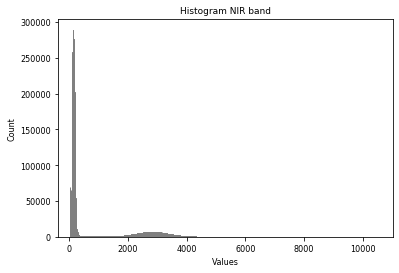

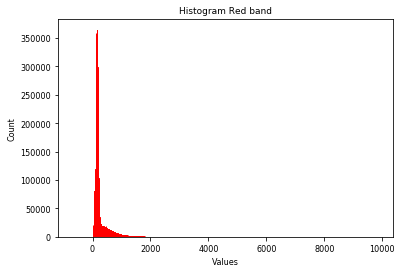

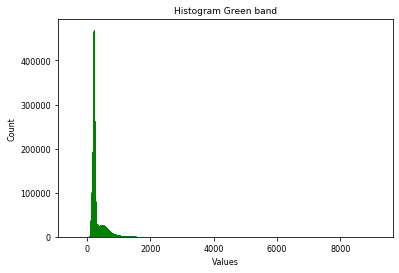

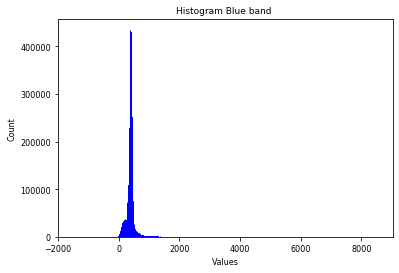

In [8]:
# With the series  freqs and vals, a function will plot histograms for bands B5, B4, B3 and B2
# # function to plot red bacn

def plot_hist(vals, freqs, min = 0, max = 6500, title='Histogram', color = 'red'):
    
    # ind = np.arange(len(vals))  # 
    #plt.bar(vals,freq, color='#7a7476',edgecolor='#7a7476')  
    #plt.ylabel('Count')
    #plt.title('Histogram Band 5')
    f, ax1 = plt.subplots(1,1)
    #ax1.bar( vals['b5'],freqs['b5'],color='gray',edgecolor='gray') #7a7476
    ax1.bar( vals ,freqs,color=color,edgecolor=color) #7a7476
    ax1.set_title(title, fontsize=9)
    ax1.set_xlabel('Values', fontsize=8)
    ax1.set_ylabel('Count', fontsize=8)
    ax1.tick_params( labelsize =8)
    ax1.set_xlim(min,max)
    plt.show()
    
# Call the function. Maximum values in the code below can be modified for visualization purposes.      
plot_hist( vals['B5'],freqs['B5'], -391, 11019,"Histogram NIR band", color = "gray")
plot_hist( vals['B4'],freqs['B4'], -1192, 10357,"Histogram Red band", color = "red")
plot_hist( vals['B3'],freqs['B3'], -919, 9652, "Histogram Green band", color =  "green")
plot_hist( vals['B2'], freqs['B2'], -2000, 9037,"Histogram Blue band ",  "blue")

It is common to apply a linear stretch, deleting  certain percent of pixels considered noise or outliers. The following example deletes 5% of the values by applying *percentile* reducers to get the percentile 2,5 and 97,5% respectively. These values are  set as *minimum* and *maximum* to scale image values to 0 and 255. 

In [10]:
# first define a function to transform the image values 
#=================================
    # function to transform the image to 8-bit (uint8):
def transformTouint8Reducers(image_hist, perc):
    NameBands = image_hist.bandNames()
    minValues = image_hist.reduceRegion(
          reducer=ee.Reducer.percentile([perc]),
          bestEffort=True,
          geometry = geom,
          scale = scale,
          maxPixels=179984674,
          ).toImage(NameBands)

    maxValues = image_hist.reduceRegion(
          reducer=ee.Reducer.percentile([100-perc]),
          bestEffort=True,
          geometry = geom,
          scale = scale,
          maxPixels=179984674,
          ).toImage(NameBands)

    return image_hist.subtract(minValues).divide(maxValues.subtract(minValues)).multiply(255).byte()    # this scale values to 0-255

# Compute the image with pixel values between 0-255
img256 = transformTouint8Reducers(image_hist,2.5)
print("done!")

done!


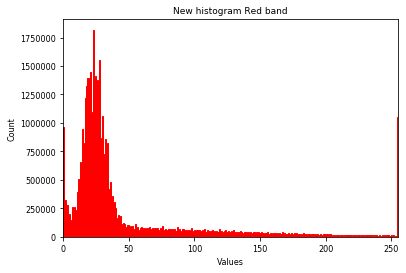

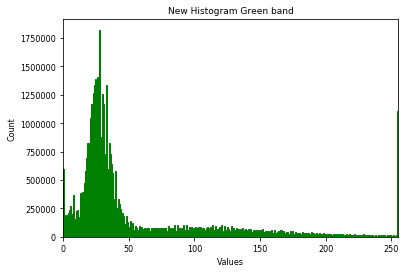

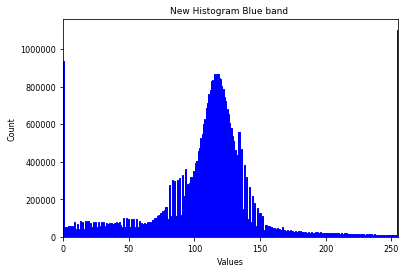

In [11]:
# Compute new histograms. 
geom = img256.geometry()
scale = img256.projection().nominalScale()
# compute the histogram
bfreq = img256.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),geometry = geom, scale = scale,
                             maxPixels = 231683685 ).getInfo()

nfreqs= dict()
nvals = dict()

for l in bfreq.keys():
    d = bfreq[l]
    freq = []
    val = []
    for k,v in d.items():
        if not(k == 'null'):
            val.append(int(k))
            freq.append(int(v))
    nfreqs[l] = freq 
    nvals[l] = val
    #print('Minimum and maximum value for : %s is %.2f %.2f' % (l, np.min(val), np.max(val) ))
  
# Call the function    
plot_hist( nvals['B4'], nfreqs['B4'], 0, 255,"New histogram Red band", color = "red")
plot_hist( nvals['B3'], nfreqs['B3'], 0, 255, "New Histogram Green band", color =  "green")
plot_hist( nvals['B2'], nfreqs['B2'], 0, 255,"New Histogram Blue band ",  color = "blue")


In [12]:
#Show the image before and after the histogram stretch
from IPython.display import display
# image before
img1  = Image(url = image_hist.getThumbUrl({'min': 0, 'max': 2048,'bands': 'B4,B3,B2'}))
# image after
img2  = Image(url = img256.getThumbUrl({'min': 0, 'max': 256,'bands': 'B4,B3,B2'}))

display(img1, img2)
# you may notice that changes are saved into the image img256